In [1]:
# Install pandas on EMR Notebook
sc.install_pypi_package("pandas==1.0.3")
sc.install_pypi_package("matplotlib==3.1.3")
sc.install_pypi_package("seaborn==0.10.1")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
5,application_1593654202360_0006,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/4a/6a/94b219b8ea0f2d580169e85ed1edc0163743f55aaeca8a44c2e8fc1e344e/pandas-1.0.3-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/d4/70/d60450c3dd48ef87586924207ae8907090de0b306af2bce5d134d78615cb/python_dateutil-2.8.1-py2.py3-none-any.whl

  Using cached https://files.pythonhosted.org/packages/4c/9b/35ab3469fd1509f7636a344940569ebfd33239673fd2318e80b4700a257c/matplotlib-3.1.3-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/8a/bb/488841f56197b13700afd5658fc279a2025a39e22449b7cf29864669b15d/pyparsing-2.4.7-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/f7/d2/e07d3ebb2bd7af696440ce7e754c59dd546ffe1bbe732c8ab68b9c834e61/cycler-0.10.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/31/b9/6202dcae729998a0ade30e80ac00f616542ef445b088ec970d407dfd41c0/kiwisolver-1.2.0-cp37-cp37m-manylinux1_x86_64.whl

  Usi

In [2]:
# import libraries
from pyspark.sql import SparkSession, Window
import pyspark.sql.functions as F
from  pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType, FloatType
from pyspark.ml.stat import Correlation
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import BinaryClassificationEvaluator, Evaluator
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import time
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Modeling
We assemble or features with `VectorAssembler` and split the full dataset into train, validation, and test sets with `randomSplit` DF method:

In [3]:
# Load features from S3 bucket from known last computation
s3_path = 's3n://emr-sparkify/processed/2020/7/1/23/16'

print(f'Loading data from {s3_path}...')
df_features_label = spark.read.csv(s3_path, header=True, inferSchema=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Loading data from s3n://emr-sparkify/processed/2020/7/1/23/16...

In [4]:
# Persist features dataframe
df_features_label.persist()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[distinctArtistsListened: int, distinctSongsListened: int, avgLength: double, isMale: int, avgItemsInSession: double, interactionsPaid: int, interactionsFree: int, statusCount307: int, statusCount404: int, statusCount200: int, About: int, Add Friend: int, Add to Playlist: int, Cancel: int, Cancellation Confirmation: int, Downgrade: int, Error: int, Help: int, Home: int, Login: int, Logout: int, NextSong: int, Register: int, Roll Advert: int, Save Settings: int, Settings: int, Submit Downgrade: int, Submit Registration: int, Submit Upgrade: int, Thumbs Down: int, Thumbs Up: int, Upgrade: int, avgSessionLength: double, location_0: double, location_1: double, location_2: double, location_3: double, location_4: double, location_5: double, location_6: double, location_7: double, location_8: double, location_9: double, location_10: double, location_11: double, location_12: double, location_13: double, location_14: double, location_15: double, location_16: double, location_17: double

In [5]:
num_cols = df_features_label.columns
num_cols.remove('isMale')
len(num_cols) # Should be 999-1=998 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

998

In [6]:
# After feature calculations the only categorical variable is "isMale", related to gender. All the others are numeric:
num_assembler = VectorAssembler(inputCols = num_cols, outputCol = "numVector")

# Scale numeric features
scaler = StandardScaler(inputCol = "numVector", outputCol = "numScaled", withStd = True, withMean = True)

# Add categorical variable "isMale":
total_assembler = VectorAssembler(inputCols = ['isMale', 'numScaled'], outputCol = 'features')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
# Split dataset
train_val_dataset, test_dataset = df_features_label.randomSplit([0.8, 0.2], seed = 0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
print('Number of train+validation dataset examples (should be 80%):', train_val_dataset.count())
print('Number of test dataset examples (should be 20%):', test_dataset.count())
print('Total number of dataset examples:', df_features_label.count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of train+validation dataset examples (should be 80%): 17852
Number of test dataset examples (should be 20%): 4426
Total number of dataset examples: 22278

##### A few observations
Although we'll be using tree-based ensemble methods, we will standardize the values. If we want to try other models that are sensible to the scale of features, we won't have problems with that.

In addition, the feature selection with those ensemble models can be easier (in our case with 204 features), since the models have the special characteristics of <a href="https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/">filter, wrapper methods and built-in feature selection</a>. We could also apply some feature selection technique (e.g. performing some correlation analysis, recurrent feature selection, etc.)

We create our custom evaluator for F1 score metric (which isn't available in Spark 2.4.6):

In [9]:
# Since in PySpark 2.4.6 (version we are using) there's no F1 score metric in BinaryClassificationEvaluator, we create our own evaluator
class F1Evaluator(Evaluator):

    def __init__(self, predictionCol = "prediction", labelCol="label"):
        self.predictionCol = predictionCol
        self.labelCol = labelCol

    def _evaluate(self, dataset):
        
        # Calculate F1 score 
        tp = dataset.where((dataset.label == 1) & (dataset.prediction == 1)).count()
        tn = dataset.where((dataset.label == 0) & (dataset.prediction == 0)).count()
        fp = dataset.where((dataset.label == 0) & (dataset.prediction == 1)).count()
        fn = dataset.where((dataset.label == 1) & (dataset.prediction == 0)).count()
        
        # Add epsilon avoid division by zero errors
        eps = 1e-6
        precision = tp / float(tp + fp + eps)
        recall = tp / float(tp + fn + eps)
        
        f1 = 2 * precision * recall / float(precision + recall + 0.00001)
        
        return f1

    def isLargerBetter(self):
        return True

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

We create 2 pipelines: one for RandomForestClassifier and other for GBTClassifier.

In [10]:
# set variable to run in EMR
spark_master = 'emr'
print('spark_master:', spark_master)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

spark_master: emr

In [11]:
def train_pipeline(model_type, dataset):    
    '''
    Creates and trains pipeline doing Cross Validation.
    Only supports RandomForestClassifier and GBTClassifier.
    
    Parameters
    ----------
    model_type: 'rf' or 'gb'. Strings for RandomForestClassifier and GBTClassifier, respectively.
    dataset: Spark dataframe with features
    
    Output
    ------
    cv_model: trained model after cross validation
    param_grid: param_grid used to train with grid search
    '''
    
    if model_type=='rf':
        model = RandomForestClassifier()
    else:
        model = GBTClassifier()
    
    print('Selected', model.__class__.__name__, 'model')
    pipeline = Pipeline(stages = [num_assembler, scaler, total_assembler, model])

    # We create a grid of parameters to search over with ParamGridBuilder
    # If cluster mode: This grid will have 2 x 2 * 2 = 8 parameter settings for CrossValidator to choose from.
    # If local model: This grid will have 1 x 1 * 1 = 1 parameter settings for CrossValidator to choose from.

    if spark_master=='local':
        print('Training locally...')
        num_folds=2
        if model_type=='rf':
            param_grid = ParamGridBuilder()\
                .addGrid(
                    model.numTrees, [10]
                ).addGrid(
                    model.maxBins, [16]
                ).addGrid(
                    model.maxDepth, [3]
                ).build()
        else:
            param_grid = ParamGridBuilder()\
                .addGrid(
                    model.maxIter, [10]
                ).addGrid(
                    model.stepSize, [0.3]
                ).addGrid(
                    model.maxDepth, [3]
                ).build()
    else:
        print('Training in cluster...')
        num_folds=3
        if model_type=='rf':
            param_grid = ParamGridBuilder()\
                .addGrid(
                    model.numTrees, [20, 30]
                ).addGrid(
                    model.maxBins, [16, 32]
                ).addGrid(
                    model.maxDepth, [3, 5]
                ).build()
        else:
            param_grid = ParamGridBuilder()\
                .addGrid(
                    model.maxIter, [150, 300]
                ).addGrid(
                    model.stepSize, [0.1,0.3]
                ).addGrid(
                    model.maxDepth, [3, 5]
                ).build()

    # We wrap the pipeline in CrossValidator instance and use our F1Evaluator
    cv = CrossValidator(estimator=pipeline, estimatorParamMaps=param_grid, evaluator=F1Evaluator(), numFolds=num_folds)

    # Run cross-validation, and choose the best set of parameters.
    print('Training', model.__class__.__name__,'...')
    cv_model = cv.fit(dataset)
    
    return cv_model, param_grid

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

We train using the the F1 score as evaluator of the Random Forest and Gradient-Boosted Trees models, tuning parameters as necessary with cross validation and pipelines with grid search. 

In [11]:
# Train Random Forest model
start = time.time()
trained_rf, param_grid_rf = train_pipeline('rf', train_val_dataset)
end = time.time()
print(f'Spent {end-start}s for training RandomForestClassifier')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Selected RandomForestClassifier model
Training in cluster...
Training RandomForestClassifier ...
Spent 370.79298877716064s for training RandomForestClassifier

In [12]:
# Save Random Forest model in S3
now = datetime.now()
s3_path = f's3n://emr-sparkify/models/{trained_rf.bestModel.stages[-1].__class__.__name__}/{now.year}/{now.month}/{now.day}/{now.hour}/'
print(f'Saving model in {s3_path}...')

trained_rf.bestModel.write().overwrite().save(s3_path)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Saving model in s3n://emr-sparkify/models/RandomForestClassificationModel/2020/7/2/0/...

In [12]:
# # Train Gradient-Boosted Trees model
# start = time.time()
# trained_gb, param_grid_gb = train_pipeline('gb', train_val_dataset)
# end = time.time()
# print(f'Spent {end-start}s for training GBTClassifier')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
# # Save Gradient-Boosted Trees model
# now = datetime.now()
# s3_path = f's3n://emr-sparkify/models/{trained_gb.bestModel.stages[-1].__class__.__name__}/{now.year}/{now.month}/{now.day}/{now.hour}/'
# print(f'Saving model in {s3_path}...')

# trained_gb.bestModel.write().overwrite().save(s3_path)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Random Forest is saved in S3, including all stages of the pipeline:
![models-s3](./media/models-s3.png)

Metadata, metrics, data from training is stored in Parquet format and with Snappy compression:
![models-parquet-snappy-s3](./media/models-parquet-snappy-s3.png)


Training metrics for models:

In [14]:
# Load model from S3
from pyspark.ml.pipeline import PipelineModel

trained_rf = PipelineModel.load('s3n://emr-sparkify/models/RandomForestClassificationModel/2020/7/2/0/')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
print('Parameters from trained model:')
print('numTrees =', trained_rf.stages[-1].getNumTrees)
print('maxBins =', trained_rf.stages[-1]._java_obj.getMaxBins())
print('maxDepth =',trained_rf.stages[-1]._java_obj.getMaxDepth())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Parameters from trained model:
numTrees = 30
maxBins = 32
maxDepth = 5

Since we are dealing with RandomForest and Gradient-Boosted Trees models, we can take advantage of feature importances that are calculated and provide useful informatio for interpretability:

In [16]:
# Display feature importances for RF and GBT (there is a "featureImportances" attribute for both)
col_names = dict(enumerate(['isMale'] + num_cols))

for model in [trained_rf]:
    importances = model.stages[-1].featureImportances 
    importances = dict(zip(importances.indices, importances.values))
    sorted_importances = {k: v for k, v in sorted(importances.items(), key=lambda item: item[1], reverse=True)}
    sorted_importances = {col_names[k]: [v] for k, v in sorted_importances.items() if col_names[k]!='label' }
    importances_df = pd.DataFrame(data=sorted_importances)
    top_20_importances_df = importances_df.iloc[:,:20]
    plt.figure(figsize=(30,15))
    plt.title(f'Top 20 Feature Importances for {model.stages[-1].__class__.__name__}', fontsize=30)
    plt.xticks(rotation=30, fontsize=18)
    plt.yticks(fontsize=18)
    sns.barplot(data=top_20_importances_df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<Figure size 3000x1500 with 0 Axes>
Text(0.5, 1.0, 'Top 20 Feature Importances for RandomForestClassificationModel')
(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]), <a list of 6 Text xticklabel objects>)
(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]), <a list of 6 Text yticklabel objects>)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

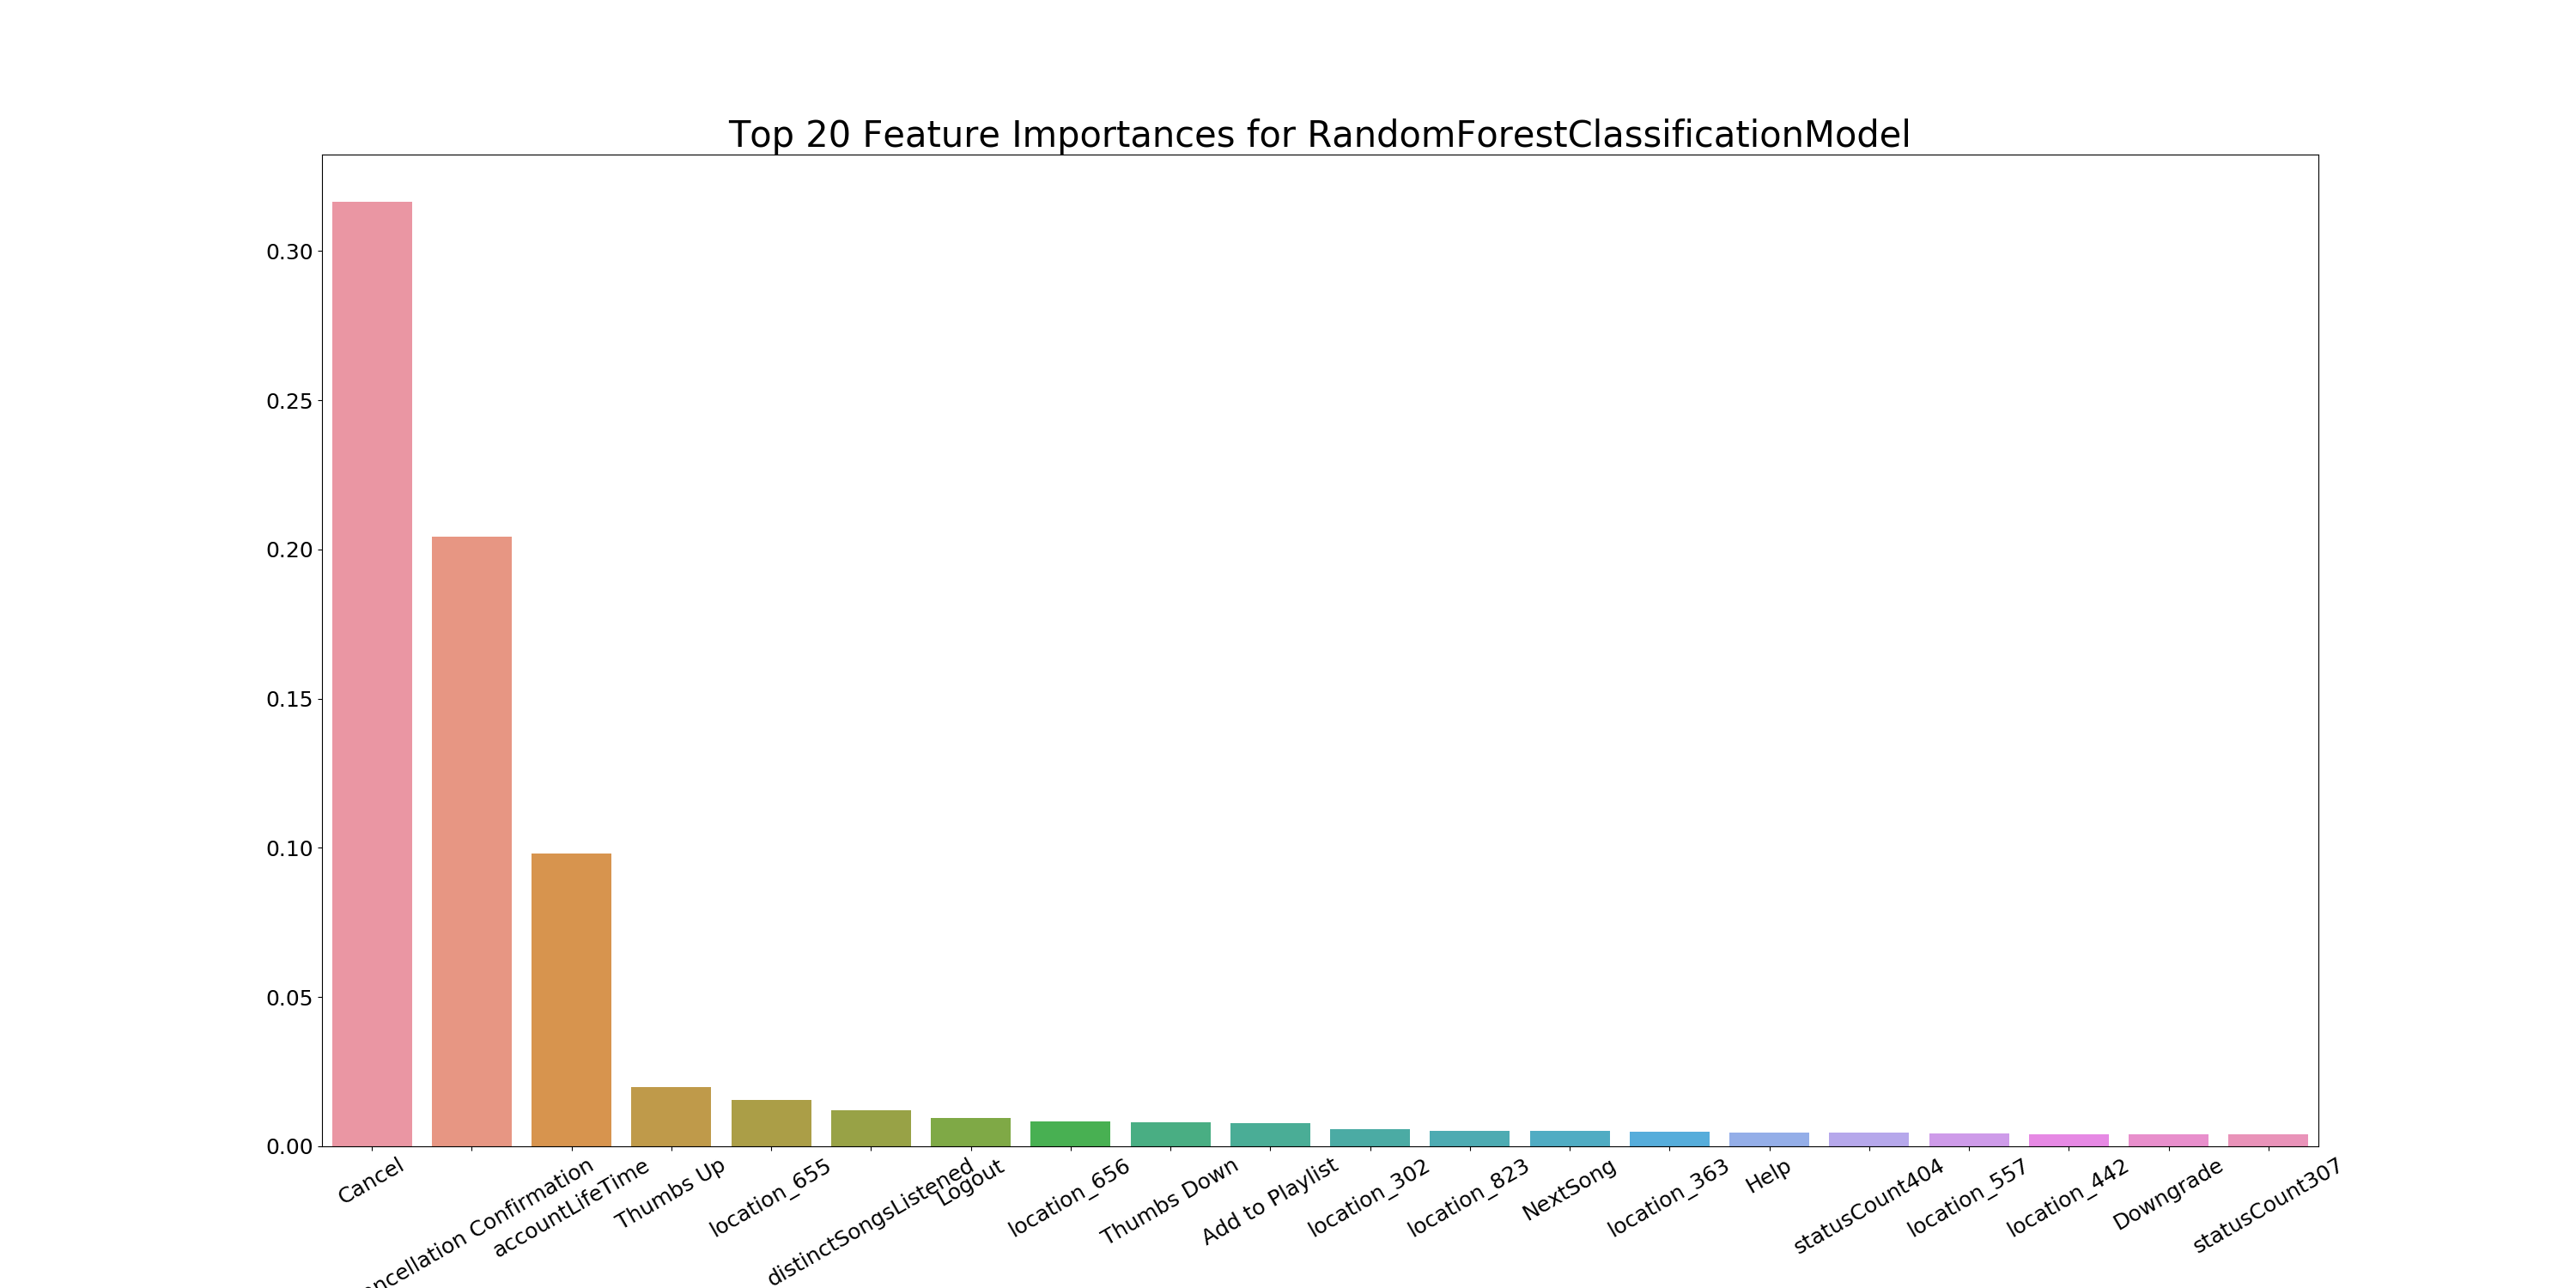

In [17]:
%matplot plt

Interestingly, the models indicate that there are locations where the users has a bigger chance of churning (we could investigate that further if it makes sense due to some external factor). Features related to devices doesn't seem to be relevant as `like Gecko` is not doesn't provide much information (is present in lots of user agent logs).

We evaluate our models with the test dataset, for both F1 score and AUC:

In [18]:
# Test with f1 score and AUC score using the test dataset
f1_evaluator = F1Evaluator()
auc_evaluator = BinaryClassificationEvaluator()

for model in [trained_rf]:
    # Get predictions using the test dataset
    predictions = model.transform(test_dataset)
    predictions = predictions.select('rawPrediction', 'probability','label','prediction')
    
    # Save prediction in my S3 bucket called emr-sparkify, partitioning by date
    now = datetime.now()
    s3_path = f's3n://emr-sparkify/predictions/{model.stages[-1].__class__.__name__}/{now.year}/{now.month}/{now.day}/{now.hour}/'

    print(f'Saving predictions in {s3_path}...')
    predictions.write.parquet(s3_path, mode='overwrite')

    f1_score = f1_evaluator.evaluate(predictions)
    auc = auc_evaluator.evaluate(predictions)
    
    print(f'Model {model.stages[-1].__class__.__name__} F1 score on test set:', f1_score)
    print(f'Model {model.stages[-1].__class__.__name__} AUC score on test set:', auc)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Saving predictions in s3n://emr-sparkify/predictions/RandomForestClassificationModel/2020/7/2/14/...
Model RandomForestClassificationModel F1 score on test set: 0.9920742072774265
Model RandomForestClassificationModel AUC score on test set: 1.0

The predictions of Random Forest are stored in S3 in Parquet format and with Snappy compression:
![models-s3](./media/s3-emr-predictions.png)

As seen predictions from the model return probablities of each class (1 churn, 0 not churn) and values in 'rawPrediction', 'probability','label','prediction' columns:

In [19]:
%spark -o preds
preds = model.transform(test_dataset.limit(5))
preds = preds.select('rawPrediction', 'probability','label','prediction')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
%local
display(preds)

Output()

![prediction-example](./media/pred-example.png)

# Conclusions

As seen in the notebook, we were able to scale to a larger volume of data and train multiple models, performing hyperparameter optimization, compare features, and develop functions for generating features and training models. 

A next step would be to create a <a href="https://spark.apache.org/docs/latest/submitting-applications.html">Spark application</a> with the already created `compute_features(df)` and `train_pipeline(model_type, dataset)` functions and creating a function for loading the model, performing inference and saving the results in S3. This way we could load data from S3 and save the predictions in a batch strategy. This would allow us to automate by creating <a href="https://docs.aws.amazon.com/emr/latest/ReleaseGuide/emr-spark-submit-step.html">EMR Steps</a> 

### Possible improvements 
- add new features <a href="#possible-features">related to other time aggregations (e.g. weeks)</a>, related to the phase (if they are paid user, free, etc.), better process user-agent data, etc.
- deal with class imbalance (with some downsampling, oversampling methods or with some technique for generating synthethic data like <a href="https://arxiv.org/pdf/1106.1813.pdf">SMOTE</a>)
- perform more feature selection - analyze correlations of computed feature for elimination (although ensemble trees models help with that), drop "Cancel" features since they are already an event associated with churn. The models performances have high correlations with "Cancel" features and when cancel actions occur we wouldn't be able to act in advance (the predictive power of the models is low, since they are predicting the obvious)
- try other models
- transform in transient EMR cluster (for batch inferences, and batch feature calculations), shutting down cluster after training and inference
- use spot instances in EMR cluster for cost opmitization
- improve performance by converting json to Parquet, compression, partitioning in S3
- adjust number of instances and types in EMR, analyse performance in Spark UI, etc.
- generate inferenced in realtime (a lot more complex: feature store for calculating and updating features, turn training model into an rest API with MLeap, etc.)
- add <a href="https://airflow.apache.org/">AirFlow</a>, <a href="https://aws.amazon.com/pt/step-functions/">AWS Step Functions</a> for orchestration, automating the calculatation features and performing inferences
- trigger marketing campaings, promotions, incentives for user to use the app (personalized e-mails, SMSs), etc.

<a id="possible-features"></a>
#### Possible improvement: Create features related to time aggregation (e.g. statistics for last N days)

Goal: from ts -> create columns with 1s and 0s, indicating whether we should select or not; then filter by 1s in newDF and reuse method `compute_features(df)`.

Pseudocode - create column endTime:
```
if last event of user is submit cancel, `endTime = ts` of last event
else `endTime = last ts of all users` (user is still active, hence the "present" is the latest time)
```
use: 
```
ts_n_days = n_days * 24 * 60 * 60 * 1000
```

create column useLog: 
```
if ts > (endTime - ts_n_days), then 1 # we select this recent event
otherwise 0 # don't select it
```
Compute features related to time aggregation (using `compute_features`) and passing as input recent rows 
```
df_recent = df.where(col('useLog')==1)
df_features_recent = compute_features(df_recent)
```
There may be users who don't have any recent action. We need to keep them and put zeros in agregations.
```
df_all_ids = df.select('userId').toPandas()
df_all_ids = df_all_ids.values.squeeze().tolist()

df_recent_ids = df_recent.select('userId').toPandas()
df_recent_ids = df_recent_ids.values.squeeze().tolist()

not_in_df_recent_ids = np.setdiff1d(df_all_ids, df_recent_ids).tolist()
vals = []
for id in not_in_df_recent_ids:
    row = []
    for c in df_features_recent.columns:
        if c=='userId':
            row.append(id)
        else:
            row.append(0)
    vals.append(row)

zeros_df = spark.createDataFrame(vals, df_features_recent.columns)
df_features_recent = df_features_recent.union(zeros_df).drop('isMale','accountLifeTime')
```
Columns related to recent events have prefix 'recent_':
```
cols = df_features_recent.columns
for c in cols:
    df_features_recent = df_features_recent.withColumnRenamed(c, 'recent_'+c)
```
Create final df with features from time aggregation and other (all calculated previously and recent ones):
```
final_df_features = df_features.join(df_features_recent, on='userId')
```
